In [8]:
import sys, logging
from pathlib import Path
import numpy as np

# Agregar src al path (ajusta si el notebook está en otro directorio)
sys.path.insert(0, str(Path.cwd() / "src"))

from patches_tda import PatchSpacePipeline, PipelineConfig, WitnessTDA

In [9]:
DATA_DIR = Path("vanhateren_imc")

PATCH_SIZE = 3
PATCHES_PER_IMAGE = 5000
TOP_DNORM_FRACTION = 0.20

TARGET_PATCH_SPACE_SIZE = 1_000_000
SUBSAMPLE_SIZE = 50_000

DENSITY_K = 15
DENSITY_TOP_FRACTION = 0.30
DENOISE_ITERATIONS = 2

SEED = 42
MAX_IMAGES = 500  # None = todas

# salida: ahora mejor como .npk (tu decisión)
OUTPUT_FILE = Path(f"X({DENSITY_K}, {DENSITY_TOP_FRACTION}).npk")


In [10]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(name)s | %(message)s")
logger = logging.getLogger("notebook")

In [11]:
if not DATA_DIR.exists():
    raise FileNotFoundError(f"No existe: {DATA_DIR}")

config = PipelineConfig(
    data_dir=DATA_DIR,
    patch_size=PATCH_SIZE,
    patches_per_image=PATCHES_PER_IMAGE,
    top_dnorm_fraction=TOP_DNORM_FRACTION,
    target_patch_space_size=TARGET_PATCH_SPACE_SIZE,
    subsample_size=SUBSAMPLE_SIZE,
    density_k=DENSITY_K,
    density_top_fraction=DENSITY_TOP_FRACTION,
    denoise_iterations=DENOISE_ITERATIONS,
    seed=SEED,
    max_images=MAX_IMAGES,
)

pipeline = PatchSpacePipeline(config)
X_pk = pipeline.run()
stats = pipeline.last_stats

X_pk.shape, X_pk.dtype

INFO | patches_tda.pipeline.patch_space_pipeline | PatchSpacePipeline inicializado con config: PipelineConfig(data_dir=WindowsPath('vanhateren_imc'), patch_size=3, patches_per_image=5000, top_dnorm_fraction=0.2, target_patch_space_size=1000000, subsample_size=50000, density_k=15, density_top_fraction=0.3, denoise_iterations=2, seed=42, max_images=500)
INFO | patches_tda.pipeline.patch_space_pipeline | Iniciando pipeline...
INFO | patches_tda.pipeline.patch_space_pipeline | Etapa 1-4: Construyendo patch space...
INFO | patches_tda.pipeline.patch_space_pipeline | Procesadas 100 imágenes, patch space: 100000/1000000
INFO | patches_tda.pipeline.patch_space_pipeline | Procesadas 200 imágenes, patch space: 200000/1000000
INFO | patches_tda.pipeline.patch_space_pipeline | Procesadas 300 imágenes, patch space: 300000/1000000
INFO | patches_tda.pipeline.patch_space_pipeline | Procesadas 400 imágenes, patch space: 400000/1000000
INFO | patches_tda.pipeline.patch_space_pipeline | Procesadas 500 i

((15000, 8), dtype('float64'))

In [12]:
print("RESULTADOS PATCH SPACE")
print("  imágenes procesadas:", stats.images_processed)
print("  parches extraídos:", f"{stats.total_patches_extracted:,}")
print("  tras D-norm:", f"{stats.patches_after_dnorm:,}")
print("  patch space size:", f"{stats.patch_space_size:,}")
print("  subsample:", f"{stats.subsample_size:,}")
print("  X(p,k) final:", f"{stats.final_size:,}")
print("  shape:", X_pk.shape)
print("  memoria MB:", X_pk.nbytes/(1024*1024))

RESULTADOS PATCH SPACE
  imágenes procesadas: 500
  parches extraídos: 2,500,000
  tras D-norm: 500,000
  patch space size: 500,000
  subsample: 50,000
  X(p,k) final: 15,000
  shape: (15000, 8)
  memoria MB: 0.91552734375


In [13]:
# Nota: np.save siempre añade .npy si no está, así que para .npk usa esto:
with open(OUTPUT_FILE, "wb") as f:
    np.save(f, X_pk)

print("Guardado en:", OUTPUT_FILE)

Guardado en: X(15, 0.3).npk


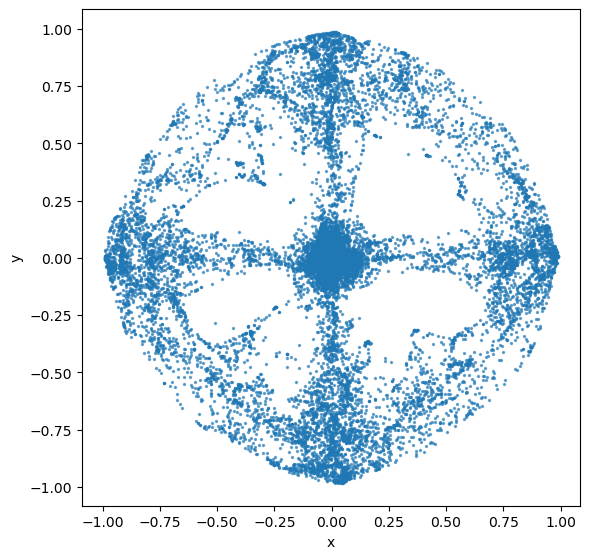

In [14]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load(OUTPUT_FILE)   # <-- ESTA LÍNEA FALTABA

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:,1], s=2, alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

In [15]:
TDA_M_POINTS = 2000
TDA_N_LANDMARKS = 100
TDA_N_WITNESSES = 1000
TDA_MAX_ALPHA_SQUARE = 0.5
TDA_LIMIT_DIMENSION = 2

In [17]:
tda = (
    WitnessTDA(
        data_path=OUTPUT_FILE,
        m_points=TDA_M_POINTS,
        n_landmarks=TDA_N_LANDMARKS,
        n_witnesses=TDA_N_WITNESSES,
        max_alpha_square=TDA_MAX_ALPHA_SQUARE,
        limit_dimension=TDA_LIMIT_DIMENSION,
        seed=SEED
    )
    .load()
    .sample()
    .compute()
)

print("Puntos usados:", tda.points_.shape[0])
print("Landmarks:", tda.landmarks_.shape[0])
print("Witnesses:", tda.witnesses_.shape[0])
print("Intervalos:", len(tda.persistence_))

INFO | patches_tda.tda.witness_tda | Datos cargados: shape=(15000, 8), rango=[-0.991, 0.989]
INFO | patches_tda.tda.witness_tda | Submuestreados 2000/15000 puntos
INFO | patches_tda.tda.witness_tda | Construyendo Witness Complex: landmarks=100, witnesses=1000
INFO | patches_tda.tda.witness_tda | Witness Complex construido: 14040 símplices, 51 intervalos de persistencia


Puntos usados: 2000
Landmarks: 100
Witnesses: 1000
Intervalos: 51


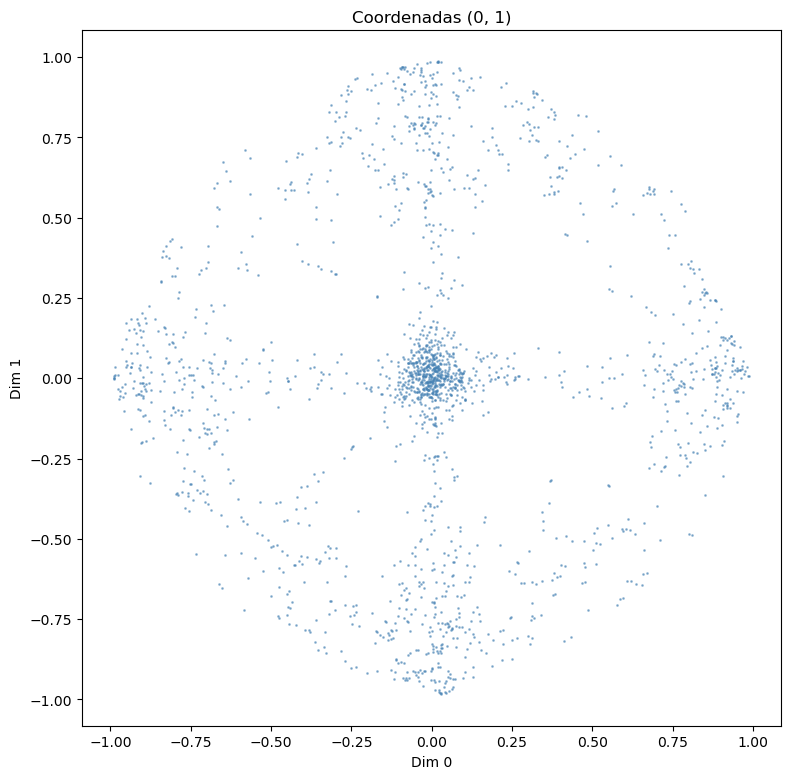

<Axes: title={'center': 'Coordenadas (0, 1)'}, xlabel='Dim 0', ylabel='Dim 1'>

In [18]:
tda.plot_projection(method="coords", coords=(0,1))


# o si quieres coordenadas:
# tda.plot_projection(method="coords", dims=(0,1))

C:\Users\werin\anaconda3\Lib\site-packages\gudhi\persistence_graphical_tools.py:134: UserWarning: usetex mode requires dvipng.
  warnings.warn("usetex mode requires dvipng.")


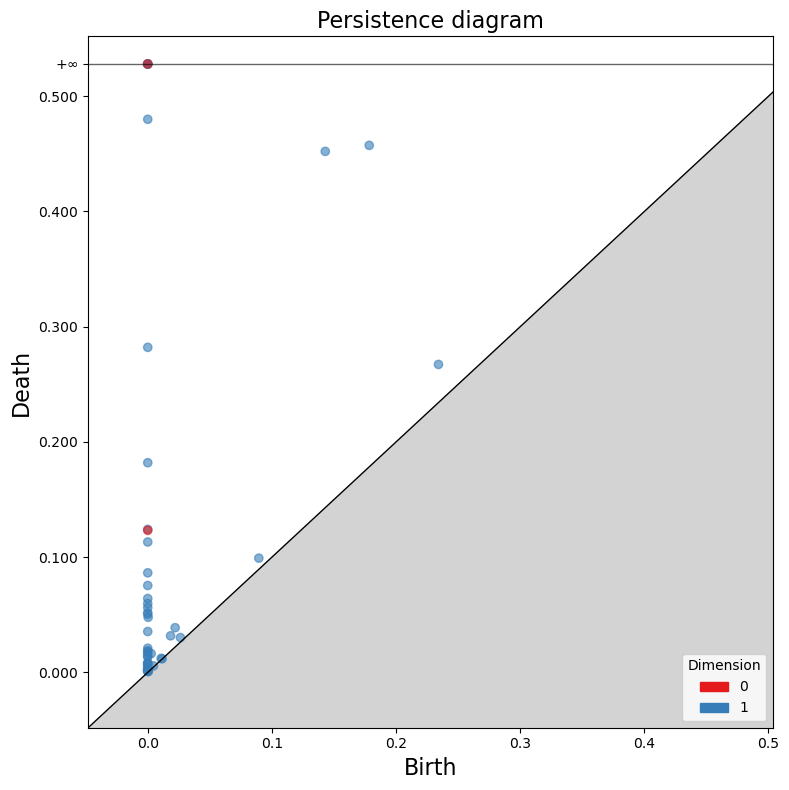

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [19]:
# Si tu WitnessTDA ya trae plot_persistence() interno:
tda.plot_persistence()

# o si usa función externa manual:
# tda.plot_persistence(plot_persistence_manual, title_prefix="Witness", max_dims=(0,1,2))


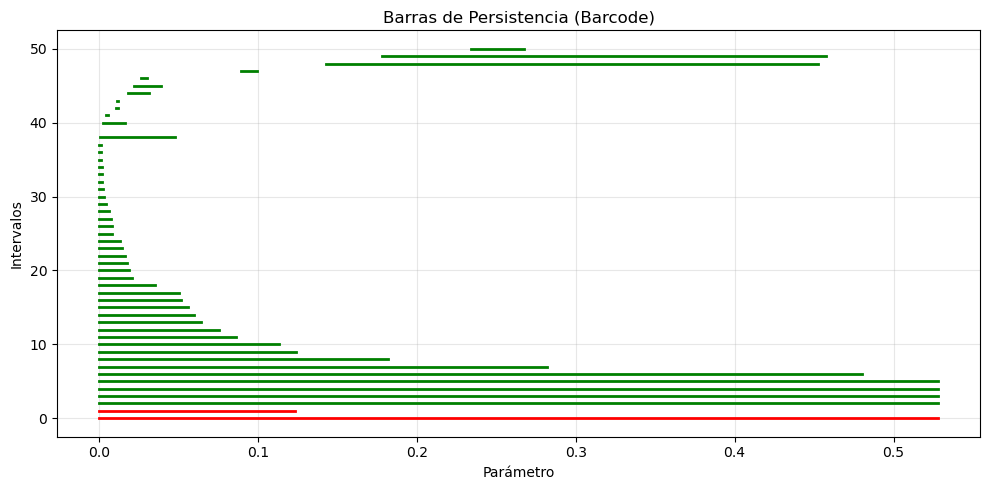

<Axes: title={'center': 'Barras de Persistencia (Barcode)'}, xlabel='Parámetro', ylabel='Intervalos'>

In [20]:
tda.plot_barcodes(max_dims=(0,1,))
